In [1]:
import io
from itertools import product
import logging; L = logging.getLogger(__name__)
from pathlib import Path
import pickle
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from tqdm.auto import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../..")
from berp.datasets.base import assert_compatible
from berp.datasets.eeg import load_eeg_dataset
from berp.viz.trf import plot_trf_coefficients, trf_to_dataframe

In [4]:
workflow = "heilbron2022"
model = "EleutherAI/gpt-neo-2.7B/n10000"
# trf_run_name = "trf-berp-cannon_3quantiles.20230207"
trf_run_name = "trf-cannon_4quantiles"

subjects = list(range(1, 20))
runs = list(range(1, 20))
stories = ["old-man-and-the-sea"]

# target_sensors = ["B19", "B20", "B22"]
target_sensors = ['B22', 'D19', 'A19', 'C22', 'C10', 'C32', 'A7', 'B4']

fig_dir = "cannon_coefficients"

normalize_X_ts = False
normalize_X_variable = True
normalize_Y = False

In [5]:
model_dir = f"../../workflow/{workflow}/results_cannon_wide/{model}/{trf_run_name}"
dataset_dir = f"../../workflow/{workflow}/data/dataset/{model}"
stimulus_dir = f"../../workflow/{workflow}/data/stimulus/{model}"

In [6]:
if fig_dir is not None:
    Path(fig_dir).mkdir(exist_ok=True)

In [7]:
# Load datasets.
ds = {}
stimulus_paths = {f"{story}/run{run}": Path(stimulus_dir) / f"{story}/run{run}.pkl"
                  for story in stories for run in runs}
combs = list(product(stories, subjects, runs))
for story, subject, run in tqdm(combs):
    ds_path = Path(dataset_dir) / story / f"sub{subject}" / f"run{run}.pkl"
    if not ds_path.exists():
        print(f"Could not find dataset {ds_path}")
        continue

    ds[story, subject, run] = load_eeg_dataset(
        [ds_path], subset_sensors=target_sensors,
        stimulus_paths=stimulus_paths,
        normalize_X_ts=normalize_X_ts, normalize_X_variable=normalize_X_variable, normalize_Y=normalize_Y).datasets[0]
    
    # DEV we just need one
    break

  0%|          | 0/361 [00:00<?, ?it/s]

In [8]:
sample_ds = next(iter(ds.values()))

In [9]:
sample_ds.variable_feature_names

['recognition_onset', 'word_frequency', 'word_surprisal']

In [10]:
all_ds = list(ds.values())
for ds in all_ds:
    assert_compatible(sample_ds, ds)

## Load pipeline

In [11]:
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else:
            return super().find_class(module, name)

In [12]:
pipeline_path = Path(model_dir) / "params" / "pipeline.pkl"
if not pipeline_path.exists():
    raise ValueError(f"Missing pipeline at {pipeline_path}")

with pipeline_path.open("rb") as f:
    pipe = CPU_Unpickler(f).load()

In [13]:
pipe.get_params()

{'confusion': tensor([[8.8851e-01, 6.8119e-04, 6.8681e-04,  ..., 3.8314e-03, 6.8305e-04,
          1.9210e-02],
         [4.7846e-04, 8.3923e-01, 6.8681e-04,  ..., 4.7892e-04, 2.1175e-02,
          1.9210e-02],
         [4.7846e-04, 6.8119e-04, 6.5041e-01,  ..., 4.7892e-04, 6.8305e-04,
          1.9210e-02],
         ...,
         [9.5693e-04, 6.8119e-04, 6.8681e-04,  ..., 6.1925e-01, 6.8305e-04,
          1.9210e-02],
         [4.7846e-04, 1.2261e-02, 1.3736e-03,  ..., 4.7892e-04, 7.7527e-01,
          1.9210e-02],
         [4.3062e-03, 2.0436e-03, 1.5797e-02,  ..., 1.4368e-02, 7.5136e-03,
          2.5078e-01]], dtype=torch.float64),
 'encoder__alpha': 51569.246541980014,
 'encoder__fit_intercept': True,
 'encoder__init_scale': 0.1,
 'encoder__n_outputs': None,
 'encoder__name': '0e963c3388644d66bd6f15b2566a8b80',
 'encoder__optim__batch_size': 512,
 'encoder__optim__early_stopping': 5,
 'encoder__optim__learning_rate': 0.01,
 'encoder__optim__n_batches': 50,
 'encoder__optim__name':

In [14]:
# pipe.prime(sample_ds)

### Extract coefficients

In [15]:
coef_df = []

ts_predictor_names, var_predictor_names = pipe.encoder_predictor_names
predictor_names = ts_predictor_names + var_predictor_names

coef_df = pd.concat({
    subject: trf_to_dataframe(encoder, predictor_names)
    for subject, encoder in pipe.encoders_.items()
}, names=["subject", "x"])

In [16]:
coef_df["sensor"] = coef_df.sensor.map(dict(enumerate(sample_ds.sensor_names)))
coef_df

predictor  lag sensor      coef  epoch_time  \
subject x                                                    
1       0              0    0    B22  0.000311        0.00   
        1              0    0    D19  0.000058        0.00   
        2              0    0    A19 -0.000002        0.00   
        3              0    0    C22 -0.000105        0.00   
        4              0    0    C10  0.000055        0.00   
...                  ...  ...    ...       ...         ...   
19      21723         27   96    C22  0.000240        0.75   
        21724         27   96    C10  0.000022        0.75   
        21725         27   96    C32  0.000083        0.75   
        21726         27   96     A7  0.000132        0.75   
        21727         27   96     B4  0.000146        0.75   

                     predictor_name  
subject x                            
1       0           all_phons_pitch  
        1           all_phons_pitch  
        2           all_phons_pitch  
        3           all_phons_pitch  
        4           all_phons_pitch  
...                             ...  
19      21723  var_word_surprisal_4  
        21724  var_word_surprisal_4  
        21725  var_word_surprisal_4  
        21726  var_word_surprisal_4  
        21727  var_word_surprisal_4  

[412832 rows x 6 columns]

### Compute recognition quantiles

In [17]:
pipe.recognition_quantile_edges_

tensor([   -inf, -4.5299, -2.3377, -0.9313,     inf])

In [18]:
recognition_quantiles = pipe._get_recognition_quantiles(sample_ds, pipe.params[0])

/net/vast-storage.ib.cluster/scratch/vast/cpl/jgauthie/scratch/bayesian-erp/scripts/visualizations/../../berp/models/trf_em.py:1109: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/native/BucketizationUtils.h:33.)
  torch.bucketize(dataset.p_candidates[:, 0], self.recognition_quantile_edges_),


In [19]:
word_id_to_quantile = dict(zip(np.arange(len(sample_ds.candidate_phonemes)), recognition_quantiles))

In [20]:
recognition_points, recognition_times = pipe.get_recognition_times(sample_ds, pipe.params[0])

Text(0.5, 15.440000000000026, 'Recognition time')

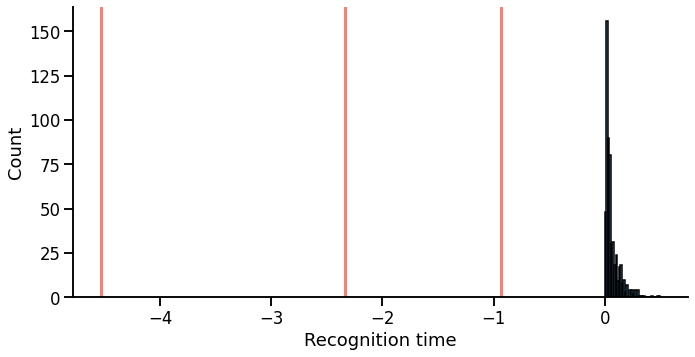

In [21]:
sns.set_context("talk")
g = sns.displot(recognition_times - sample_ds.word_onsets, aspect=2)
ax = g.axes.ravel()[0]
for quantile_edge in pipe.recognition_quantile_edges_[1:-1].numpy():
    ax.axvline(quantile_edge, linewidth=3, color="salmon")
ax.set_xlabel("Recognition time")

Text(0.5, 15.440000000000026, 'Recognition point (phoneme)')

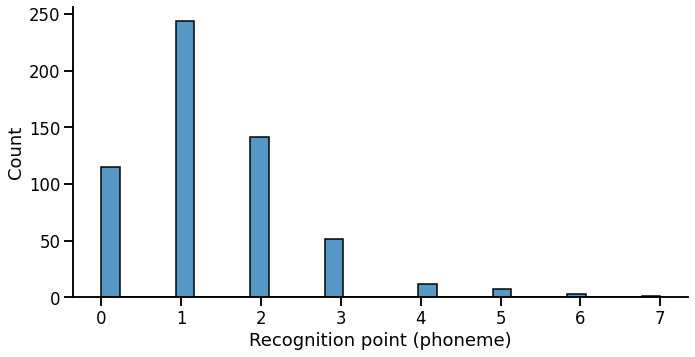

In [22]:
g = sns.displot(recognition_points, aspect=2)
ax = g.axes.ravel()[0]
ax.set_xlabel("Recognition point (phoneme)")

In [23]:
torch.where(recognition_points == 5)

(tensor([ 59, 210, 228, 249, 455, 500, 553]),)

In [24]:
def get_strs(i, ctx=5):
    phon_strs = sample_ds.candidate_phonemes[max(0,i-ctx):i+1, 0, :].numpy()
    phon_strs = [[sample_ds.phonemes[idx] for idx in phon_str] for phon_str in phon_strs]
    return " ".join("".join(phon_str).replace("_", "") for phon_str in phon_strs)

In [25]:
get_strs(228)

'ɪɹoʊʒʌnz ɪn ʌ fɪʃlʌs dɛzɚt ɛvɹiθɪŋ'

## Overall plots

In [63]:
def plot_cannon(coef_df, subjects=None, pool_sensors=True, feature_names=None):
    if pool_sensors:
        coef_df = coef_df.groupby(["subject", "predictor_name", "epoch_time"]).coef.mean().reset_index().set_index("subject")
    if feature_names is None:
        feature_names = sample_ds.variable_feature_names
        
    n_rows = len(feature_names)
    n_cols = 1 if pool_sensors else len(sample_ds.sensor_names)
    f, axs = plt.subplots(n_rows, n_cols, figsize=(15 if pool_sensors else 7 * n_cols, 7 * n_rows))
    if n_cols == 1:
        axs = axs[:, np.newaxis]
    assert axs.ndim == 2

    for i, (feature_axs, feature_name) in enumerate(zip(tqdm(axs), feature_names)):
        if pool_sensors:
            col_iter = [(1, (feature_axs[0], "ALL"))]
        else:
            col_iter = enumerate(zip(tqdm(feature_axs), ds.sensor_names))

        for j, (sensor_ax, sensor) in col_iter:
            to_plot = coef_df if pool_sensors else coef_df[coef_df.sensor == sensor]
            if subjects is not None:
                to_plot = to_plot.loc[subjects]

            plot_legend = j == n_cols - 1
            plot_trf_coefficients(to_plot, predictor_match_patterns=[f"{feature_name}_"], ax=sensor_ax, errorbar="se",
                                  legend=plot_legend)

            sensor_ax.set_title(f"{feature_name} @ {sensor}")
            
    title_annotation = "" if subjects is None else " (subjects " + ", ".join(map(str, subjects)) + ")"
    f.suptitle(f"Cannon coefficients{title_annotation}")

  0%|          | 0/3 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


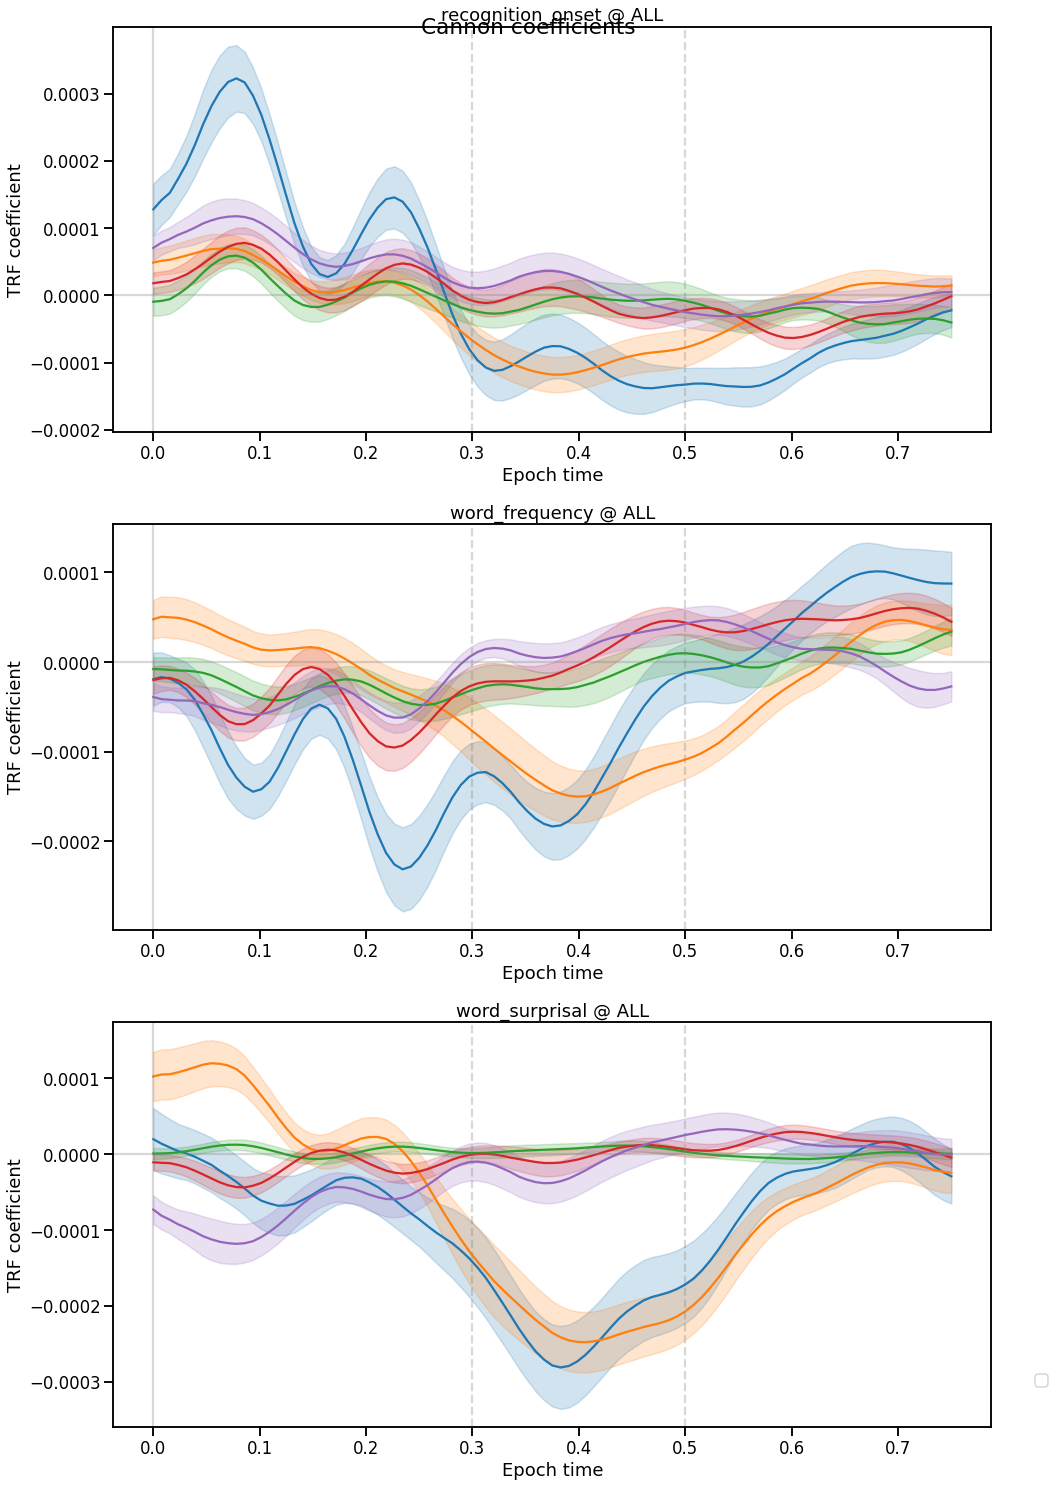

In [64]:
plot_cannon(coef_df, pool_sensors=True)

if fig_dir is not None:
    plt.savefig(f"{fig_dir}/{trf_run_name}.pooled_sensors.pdf")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

  0%|          | 0/8 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

  0%|          | 0/8 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

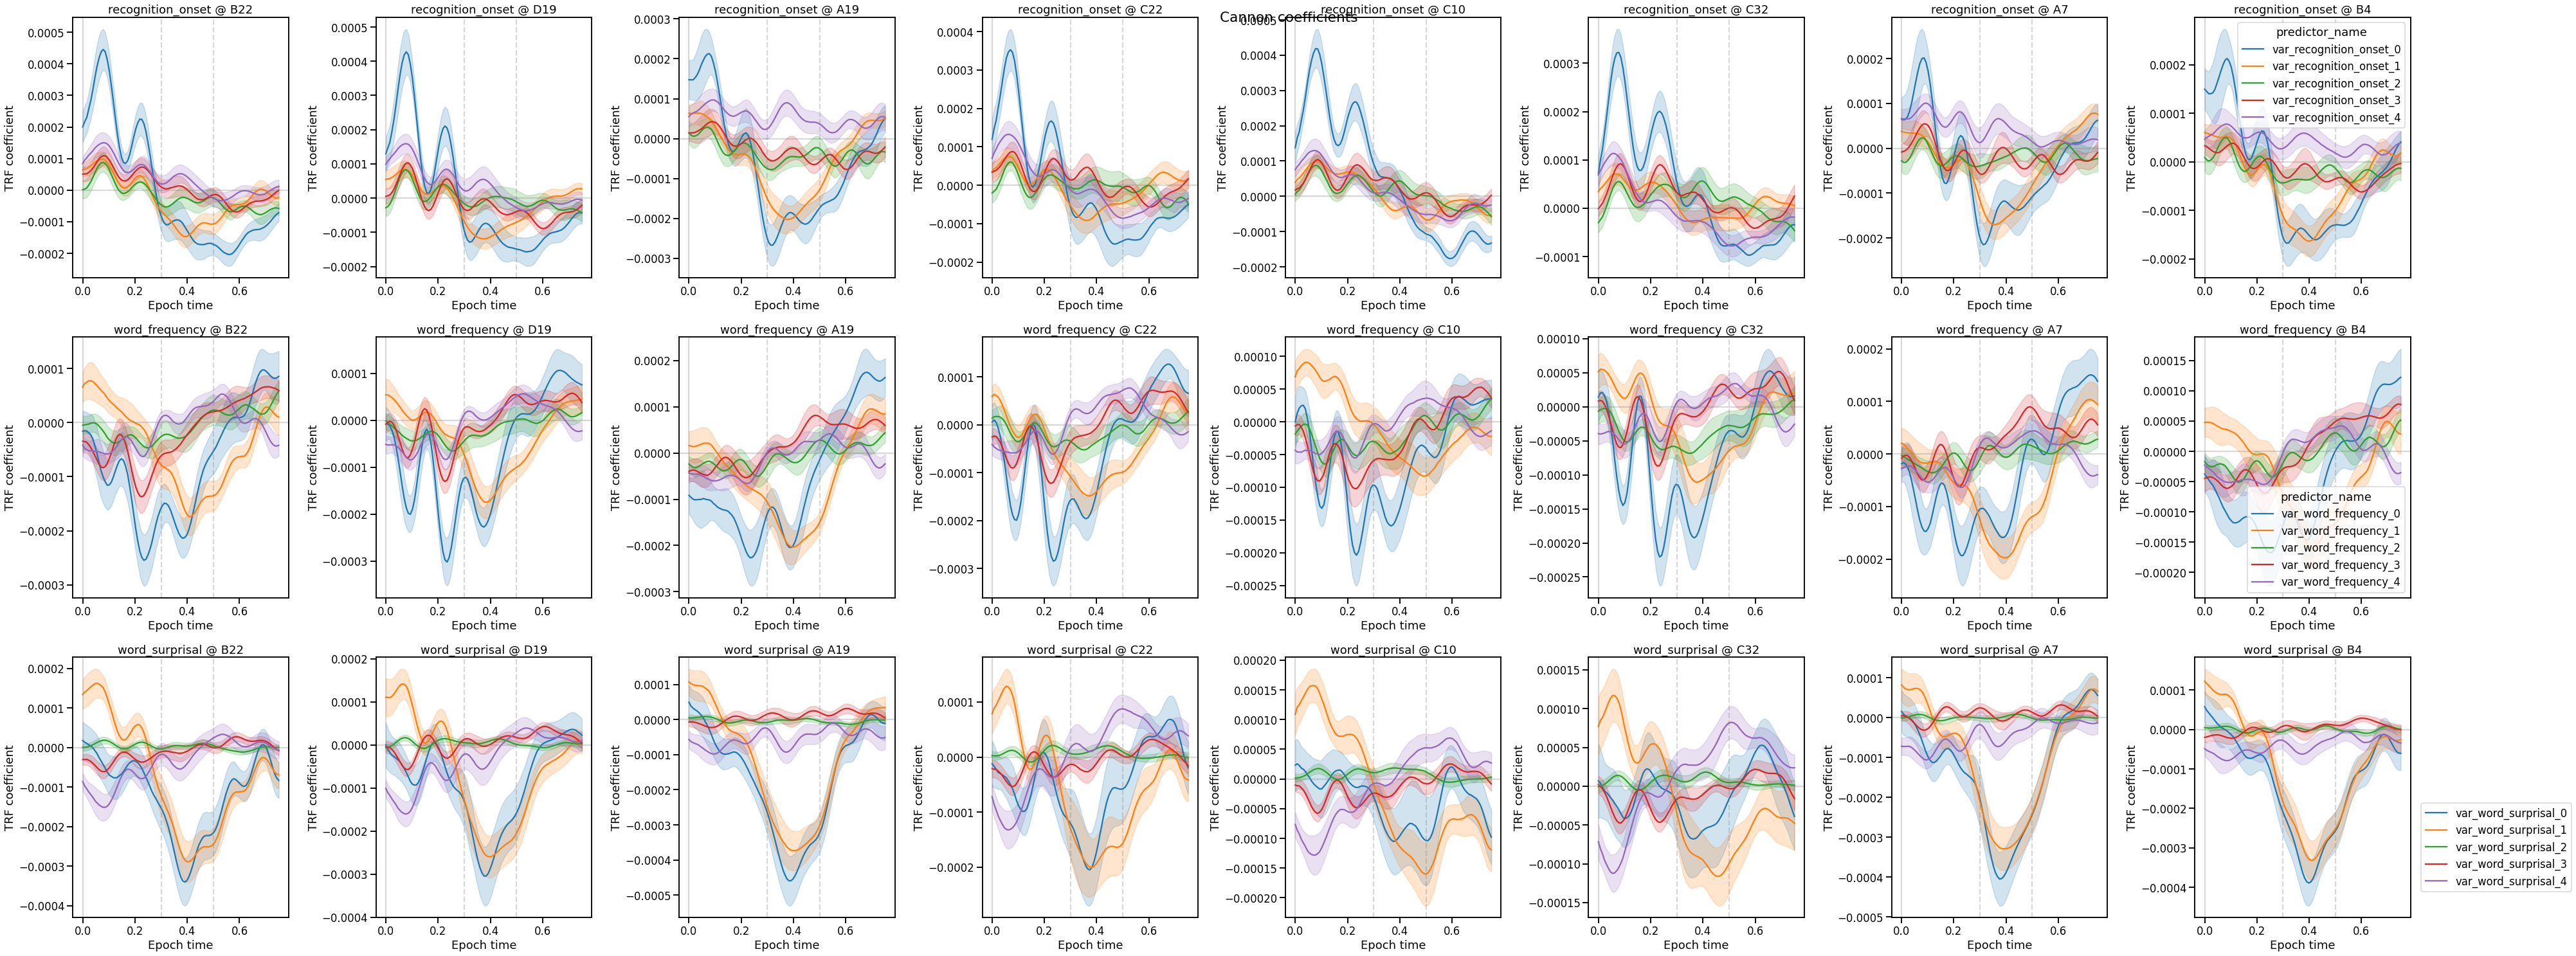

In [65]:
plot_cannon(coef_df, pool_sensors=False)

if fig_dir is not None:
    plt.savefig(f"{fig_dir}/{trf_run_name}.split_sensors.pdf")

### Plot rollouts

Plot the expected response to a word from each quantile by sampling appropriate freq/surprisal values.

In [66]:
# recognition_quantiles = pipe._get_recognition_quantiles(sample_ds, pipe.params[0])

In [67]:
# recognition_quantiles

In [68]:
# from copy import deepcopy
# myds = sample_ds[int(0.8828 * 128):int((0.8828 + pipe.encoder.tmax) * 128)]
# pipe.predict(myds)

In [69]:
# rollout_df = []
# from berp.util import time_to_sample

# for i, (word_quantile, word_features) in enumerate(zip(tqdm(recognition_quantiles.numpy()), sample_ds.X_variable.numpy())):
#     # Subset the dataset to contain just this word
#     word_onset, word_offset = sample_ds.word_onsets[i], sample_ds.word_offsets[i]
#     X_ts = sample_ds.X_ts[time_to_sample(word_onset, ds.sample_rate) :
#                           time_to_sample(word_offset, ds.sample_rate)]

# #     for subject in subjects:
# #         encoder = pipe.encoders_[str(subject)]
# #         coefs = encoder.coef_[predictor_idxs, :, :].numpy()
        
# #         # Repeat variable-onset features, once for the per-quantile coefs and
# #         # once for the global coefs (match above `predict_idx` positioning)
# #         predictors = np.tile(word_features, (2,))
        
# #         n_predictors, n_lags, n_sensors = coefs.shape
# #         coefs = coefs.reshape(n_predictors, -1)
        
# #         rollout = predictors @ coefs
# #         rollout = rollout.reshape(n_lags, n_sensors)
        
# #         # Add word onset feature
# #         rollout += encoder.coef_[predictor_names.index("word_onset")].numpy()
        
# #         for lag, sensor in np.ndindex(n_lags, n_sensors):
# #             rollout_df.append((i, word_quantile, subject, lag, target_sensors[sensor], rollout[lag, sensor]))

In [70]:
# rollout_df = []

# for i, (word_quantile, word_features) in enumerate(zip(tqdm(recognition_quantiles.numpy()), sample_ds.X_variable.numpy())):
#     # Get relevant coef columns
#     predictor_idxs = [predictor_names.index(f"var_{feature}_{word_quantile + 1}")
#                       for feature in sample_ds.variable_feature_names]
#     # Add global coefs
#     predictor_idxs += [predictor_names.index(f"var_{feature}_0")
#                        for feature in sample_ds.variable_feature_names]

#     for subject in subjects:
#         encoder = pipe.encoders_[str(subject)]
#         coefs = encoder.coef_[predictor_idxs, :, :].numpy()
        
#         # Repeat variable-onset features, once for the per-quantile coefs and
#         # once for the global coefs (match above `predict_idx` positioning)
#         predictors = np.tile(word_features, (2,))
        
#         n_predictors, n_lags, n_sensors = coefs.shape
#         coefs = coefs.reshape(n_predictors, -1)
        
#         rollout = predictors @ coefs
#         rollout = rollout.reshape(n_lags, n_sensors)
        
#         # Add word onset feature
#         rollout += encoder.coef_[predictor_names.index("word_onset")].numpy()
        
#         for lag, sensor in np.ndindex(n_lags, n_sensors):
#             rollout_df.append((i, word_quantile, subject, lag, target_sensors[sensor], rollout[lag, sensor]))

In [71]:
# rollout_df = pd.DataFrame(rollout_df, columns=["word_idx", "word_quantile", "subject", "lag", "sensor", "value"])

In [72]:
# f, ax = plt.subplots(figsize=(15, 15))
# ax.axvline(0, c="gray")
# ax.axhline(0, c="gray")
# ax.axvline(0.3, c="gray", linestyle="--", alpha=0.3)
# ax.axvline(0.5, c="gray", linestyle="--", alpha=0.3)

# rollout_df["time"] = rollout_df.lag / 128
# sns.lineplot(data=rollout_df, x="time", y="value", hue="word_quantile", ax=ax)

# if fig_dir is not None:
#     plt.savefig(f"{fig_dir}/{trf_run_name}.rollout.pdf")

In [73]:
# rollout_df[rollout_df.time.between(0.1, 0.2)].groupby("word_quantile").apply(lambda xs: xs.reset_index().set_index("time").value.idxmin())

In [74]:
# rollout_df.to_csv(f"rollout_{trf_run_name}.csv")

In [75]:
# coef_df_sub = coef_df.loc["1"]
# pool_sensors = False

# n_rows = len(sample_ds.variable_feature_names)
# n_cols = 1 if pool_sensors else len(sample_ds.sensor_names)
# f, axs = plt.subplots(n_rows, n_cols, figsize=(20 if pool_sensors else 10 * n_cols, 15))

# # if pool_sensors:
# #     coef_df = coef_df.groupby(["subject", "predictor_name", "epoch_time"]).coef.mean().reset_index()

# for i, (feature_axs, feature_name) in enumerate(zip(tqdm(axs), sample_ds.variable_feature_names)):
#     if pool_sensors:
#         col_iter = [(1, (feature_axs, "ALL"))]
#     else:
#         col_iter = enumerate(zip(tqdm(feature_axs), ds.sensor_names))

#     for j, (sensor_ax, sensor) in col_iter:
#         to_plot = coef_df_sub if pool_sensors else coef_df_sub[coef_df_sub.sensor == sensor]
#         if subjects is not None:
#             to_plot = to_plot.loc[subjects]

#         plot_trf_coefficients(to_plot, predictor_match_patterns=[f"{feature_name}_\d"], ax=sensor_ax)

#         sensor_ax.set_title(f"{feature_name} @ {sensor}")

### Plot combined surprisal coefficients

In [76]:
combine_features = tuple(set(re.sub("_(\d+)$", "", predictor) for predictor in var_predictor_names))
cdf = coef_df[coef_df.predictor_name.str.startswith(combine_features)].reset_index()
cdf["base_predictor"] = cdf.predictor_name.str.replace(r"_(\d+)$", "", regex=True)
cdf["quantile"] = cdf.predictor_name.str.extract(r"_(\d+)").astype(int)
cdf = cdf.set_index(["quantile", "base_predictor", "subject", "lag", "sensor"])
cdf = cdf.coef + cdf.loc[0].coef
cdf = cdf.reset_index()
cdf = cdf[cdf["quantile"] != 0]
cdf["epoch_time"] = cdf.lag / 128
cdf

base_predictor subject  lag sensor  quantile      coef  \
1       var_recognition_onset       1    0    A19         1  0.000006   
2       var_recognition_onset       1    0    A19         2  0.000129   
3       var_recognition_onset       1    0    A19         3  0.000039   
4       var_recognition_onset       1    0    A19         4  0.000123   
6       var_recognition_onset       1    0     A7         1 -0.000059   
...                       ...     ...  ...    ...       ...       ...   
221154     var_word_surprisal       9   96    C32         4  0.000272   
221156     var_word_surprisal       9   96    D19         1  0.000103   
221157     var_word_surprisal       9   96    D19         2  0.000216   
221158     var_word_surprisal       9   96    D19         3  0.000278   
221159     var_word_surprisal       9   96    D19         4  0.000190   

        epoch_time  
1             0.00  
2             0.00  
3             0.00  
4             0.00  
6             0.00  
...            ...  
221154        0.75  
221156        0.75  
221157        0.75  
221158        0.75  
221159        0.75  

[176928 rows x 7 columns]

In [77]:
comb_data_df = cdf

In [84]:
# if "berp" in trf_run_name:
#     pretty_desc = {1: "early", 2: "mid", 3: "late"}  # for recognitino time splits
# else:
#     pretty_desc = {1: "high", 2: "mid", 3: "low"}  # for surprisal splits
# comb_data_df["quantile_pretty"] = comb_data_df["quantile"].map(pretty_desc)
comb_data_df["quantile_pretty"] = comb_data_df["quantile"].astype(str)
comb_data_df["predictor_name"] = comb_data_df.base_predictor.str.cat(comb_data_df.quantile_pretty, sep="_")

In [85]:
comb_data_df

base_predictor subject  lag sensor  quantile      coef  \
1       var_recognition_onset       1    0    A19         1  0.000006   
2       var_recognition_onset       1    0    A19         2  0.000129   
3       var_recognition_onset       1    0    A19         3  0.000039   
4       var_recognition_onset       1    0    A19         4  0.000123   
6       var_recognition_onset       1    0     A7         1 -0.000059   
...                       ...     ...  ...    ...       ...       ...   
221154     var_word_surprisal       9   96    C32         4  0.000272   
221156     var_word_surprisal       9   96    D19         1  0.000103   
221157     var_word_surprisal       9   96    D19         2  0.000216   
221158     var_word_surprisal       9   96    D19         3  0.000278   
221159     var_word_surprisal       9   96    D19         4  0.000190   

        epoch_time quantile_pretty           predictor_name  
1             0.00               1  var_recognition_onset_1  
2             0.00               2  var_recognition_onset_2  
3             0.00               3  var_recognition_onset_3  
4             0.00               4  var_recognition_onset_4  
6             0.00               1  var_recognition_onset_1  
...            ...             ...                      ...  
221154        0.75               4     var_word_surprisal_4  
221156        0.75               1     var_word_surprisal_1  
221157        0.75               2     var_word_surprisal_2  
221158        0.75               3     var_word_surprisal_3  
221159        0.75               4     var_word_surprisal_4  

[176928 rows x 9 columns]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

  0%|          | 0/8 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

  0%|          | 0/8 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

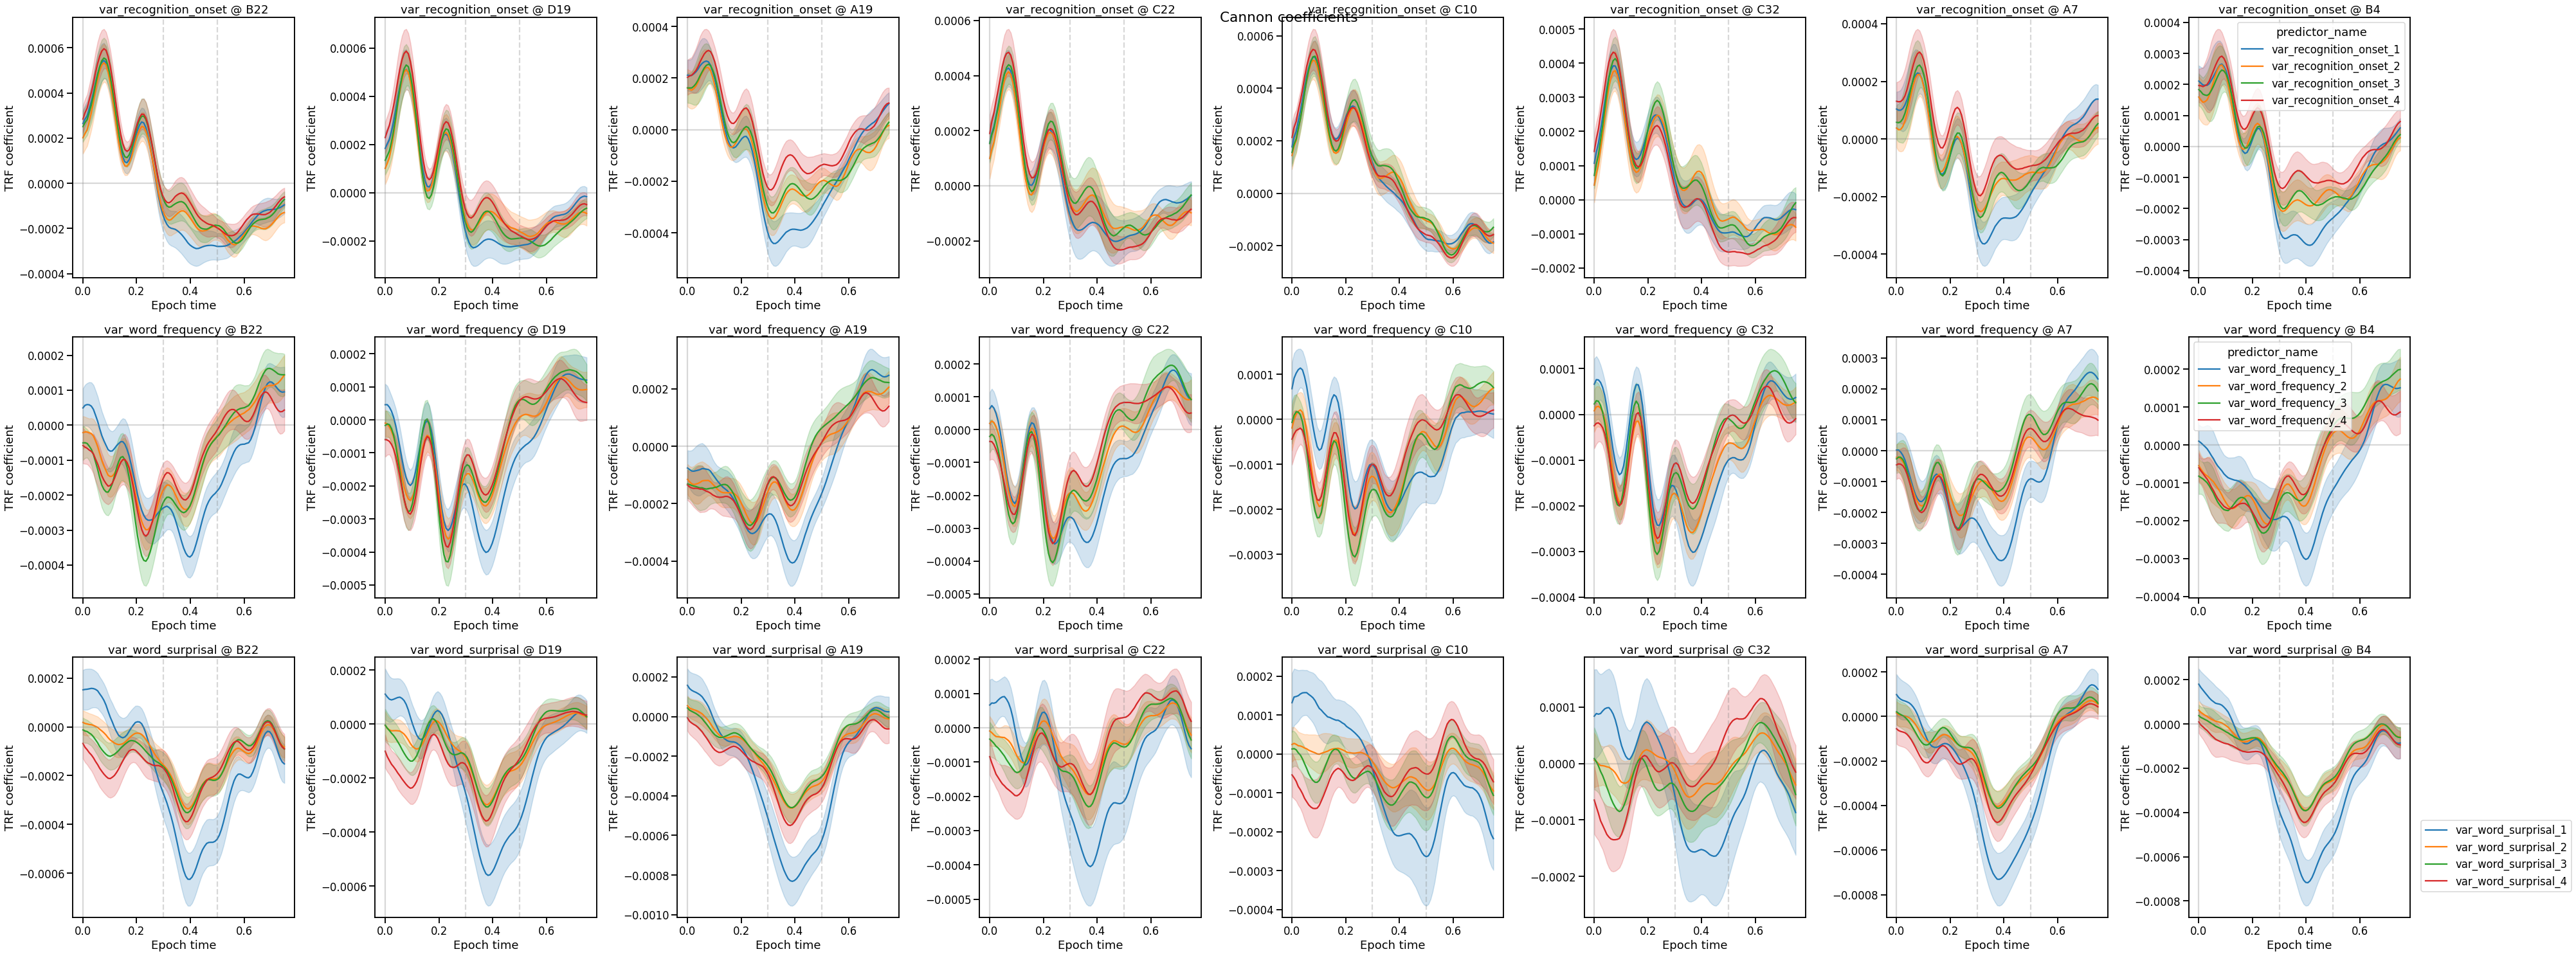

In [86]:
plot_cannon(comb_data_df, pool_sensors=False, feature_names=comb_data_df.base_predictor.unique())

if fig_dir is not None:
    plt.savefig(f"{fig_dir}/{trf_run_name}.combine_quants.split_sensors.pdf")

In [87]:
# f, ax = plt.subplots(figsize=(15, 7))
# hue_order = [
#     "var_word_surprisal_early",
#     # "var_word_surprisal_low",
#     "var_word_surprisal_mid",
#     "var_word_surprisal_late",
#     # "var_word_surprisal_high"
# ]
# plot_trf_coefficients(comb_data_df, predictor_match_patterns=[f"var_word_surprisal"],
#                       ax=ax, errorbar="se", hue_order=hue_order)

In [ ]:
all_comb_df = comb_data_df.groupby(["subject", "lag", "sensor", "quantile_pretty", "epoch_time"]).sum().reset_index()
all_comb_df["predictor_name"] = "recog_" + all_comb_df.quantile_pretty

plot_cannon(all_comb_df, pool_sensors=False, feature_names=["recog"])

# f, ax = plt.subplots(figsize=(15, 7))
# hue_order = [
#     "early", "mid", "late",
#     # "low", "mid", "high",
# ]
# plot_trf_coefficients(all_comb_df, # predictor_match_patterns=[f"var_word_surprisal"],
#                       ax=ax, errorbar="se", hue_order=hue_order)

AssertionError: 